In [67]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Отрисовка графиков

In [68]:
def plot_car_data(car_data):
    """
    Функция для построения графиков скорости и пути для нескольких машин.

    Parameters:
    - car_data: список данных для каждой машины. Каждый элемент списка должен быть кортежем,
                содержащим время, скорость, пройденный путь и позиции заправок.
    """
    # Построение графиков
    plt.figure(figsize=(12, 6))

    # Графики для каждой машины
    for i, data in enumerate(car_data):
        time, velocity, positions, refuel_positions = data

        # График скорости
        plt.subplot(2, 1, 1)
        plt.plot(time, velocity, label=f"Машина {i + 1}", linestyle='-', color=f"C{i}")

        # График пути
        plt.subplot(2, 1, 2)
        plt.plot(time, positions, label=f"Машина {i + 1}", linestyle='-', color=f"C{i}")
        plt.scatter([time[positions.index(rp)] for rp in refuel_positions], refuel_positions,
                    color=f"C{i}", label=f"Заправки Машины {i + 1}", zorder=5)

    # Настройка графиков
    plt.subplot(2, 1, 1)
    plt.xlabel("Время (с)")
    plt.ylabel("Скорость (м/с)")
    plt.title("График скорости автомобилей от времени")
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.xlabel("Время (с)")
    plt.ylabel("Пройденный путь (м)")
    plt.title("График пути автомобилей от времени")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

### Сначало просто просчитаем три разныем машины с учетом заправок

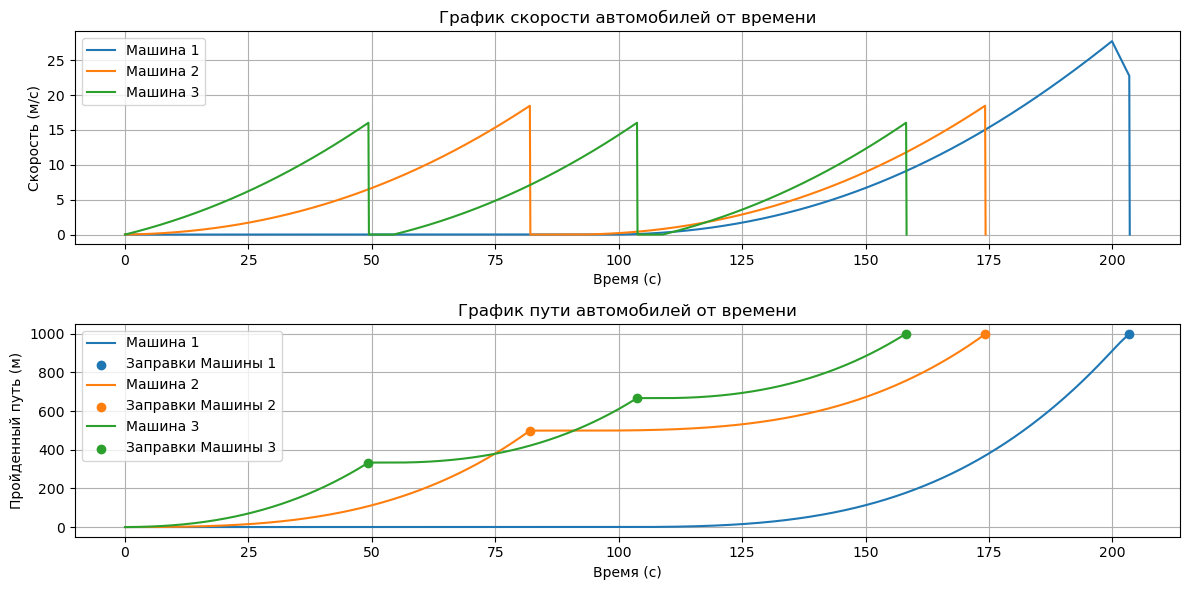

In [69]:
# Исходные данные
m_o = 1000  # масса объекта без топлива (кг)
m_f0 = 500  # начальная масса топлива (кг)
dot_m_f = 5  # расход топлива (кг/с)
F_engine = 2000  # сила двигателя (Н)
v_0 = 0  # начальная скорость (м/с)

# Параметры замедления
C_d = 0.47  # коэффициент сопротивления воздуха
rho = 1.225  # плотность воздуха (кг/м^3)
A = 0.5  # площадь поперечного сечения (м^2)
mu = 0.135  # коэффициент трения
g = 9.81  # ускорение свободного падения (м/с^2)

# Параметры заправки
refuel_time = 30  # время заправки (с)
fuel_station_interval = 1150  # расстояние между заправками (м)

# Шаг моделирования
dt = 0.1  # шаг времени (с)
total_time = 1000  # общее время моделирования (с)

# Моделируем каждую машину
def calculate_resistance(m_o, v, m_f):
    F_drag = 0.5 * C_d * rho * A * v**2
    F_friction = mu * (m_o + m_f) * g
    return F_drag + F_friction

def simulate_car(car):
    # Начальные параметры для каждой машины
    m_o = car["m_o"]
    m_f0 = car["m_f0"]
    dot_m_f = car["dot_m_f"]
    F_engine = car["F_engine"]
    v_0 = car["v_0"]
    fuel_station_interval = car["fuel_station_interval"]
    max_refuels = car["max_refuels"]
    refuel_time = car["refuel_time"]

    # Переменные для симуляции
    fuel_mass = m_f0
    time = [0]
    velocity = [v_0]
    position = 0
    positions = [0]
    refuel_positions = []
    current_time = 0
    refueling = False
    refuel_count = 0

    # Моделирование движения
    while current_time < total_time and refuel_count < max_refuels:
        # Обновляем время
        current_time += dt
        if not refueling:
            # Расход топлива
            if fuel_mass > 0:
                fuel_mass -= dot_m_f * dt
                if fuel_mass < 0:
                    fuel_mass = 0

            # Сила тяги и сопротивления
            if fuel_mass > 0:
                F_resistance = calculate_resistance(m_o, velocity[-1], fuel_mass)
                acceleration = (F_engine - F_resistance) / (m_o + fuel_mass)
            else:  # Нет топлива, только замедление
                F_resistance = calculate_resistance(m_o, velocity[-1], 0)
                acceleration = -F_resistance / m_o

            # Обновляем скорость и положение
            new_velocity = max(0, velocity[-1] + acceleration * dt)
            position += new_velocity * dt

            # Проверяем заправку
            if position >= fuel_station_interval:
                position = 0  # Обнуляем позицию до следующей заправки
                refueling = True  # Начинаем заправку
                refuel_start_time = current_time
                refuel_count += 1
                refuel_positions.append(positions[-1])  # Запоминаем место заправки
                new_velocity = 0  # Скорость падает до нуля на заправке

        else:  # Процесс заправки
            new_velocity = 0  # Скорость на заправке равна нулю
            if current_time - refuel_start_time >= refuel_time:
                refueling = False  # Завершаем заправку
                fuel_mass = m_f0  # Восстанавливаем топливо

        # Записываем значения
        time.append(current_time)
        velocity.append(new_velocity)
        positions.append(positions[-1] + velocity[-1] * dt)

    return time, velocity, positions, refuel_positions

# Пример данных для разных машин
cars = [
    {"m_o": 1000, "m_f0": 1000, "dot_m_f": 5, "F_engine": 2000, "v_0": 0, "fuel_station_interval": 1000, "max_refuels": 1, "refuel_time": 0},
    {"m_o": 1000, "m_f0": 500, "dot_m_f": 5, "F_engine": 2000, "v_0": 0, "fuel_station_interval": 500, "max_refuels": 2, "refuel_time": 10},
    {"m_o": 1000, "m_f0": 334, "dot_m_f": 5, "F_engine": 2000, "v_0": 0, "fuel_station_interval": 334, "max_refuels": 3, "refuel_time": 5}
]

# Симуляция для всех машин
car_data = []
for car in cars:
    car_data.append(simulate_car(car))

plot_car_data(car_data)

### Добавим ГА для оптимизации кол ва топлива с учетом разного колва остановок
###### Также поставим перед ГА две задачи - доехать быстрее всех и доехать за минимальное кол во топлива (там тумблер есть можно ставить 0.3 0.7, сейчас стоит 0 1)

In [70]:
# Фитнес-функция для получения времени и топлива
def fitness_function(individual, car):
    fuel_amount = individual[0]  # Получаем значение топлива для данной хромосомы
    car["m_f0"] = fuel_amount  # Устанавливаем это значение в параметры машины
    
    # Симуляция движения
    time, velocity, positions, refuel_positions = simulate_car(car)
    
    # Оценка: для минимизации времени и топлива, фитнес - это комбинированная функция
    total_time = time[-1]
    total_fuel = (car["m_f0"] - positions[-1] * car["dot_m_f"] * 0.1)  # Приблизительный расчет топлива
    
    # Взвешенная сумма времени и топлива (можно отрегулировать веса)
    weight_time = 0  # На что акцентирует внимание ГА - СКОРОСТЬ
    weight_fuel = 1  # На что акцентирует внимание ГА - ТОПЛИВО
    fitness_value = weight_time * total_time + weight_fuel * total_fuel
    
    return fitness_value

# Генерация случайной особи (параметр топлива)
def generate_individual():
    return [random.randint(100, 500)]  # Случайное значение топлива от 100 до 1000

# Операция кроссинговера (перемешивание топлива двух особей)
def crossover(parent1, parent2):
    return [(parent1[0] + parent2[0]) // 2], [(parent1[0] + parent2[0]) // 2]

# Операция мутации (случайное изменение топлива)
def mutate(individual):
    if random.random() < 0.1:  # 10% шанс на мутацию
        individual[0] = random.randint(100, 500)
    return individual

# Основной цикл ГА для одной машины
def genetic_algorithm_for_car(car, population_size, generations):
    # Генерация начальной популяции
    population = [generate_individual() for _ in range(population_size)]
    
    for generation in range(generations):
        # Оценка приспособленности всех особей
        fitness_values = [fitness_function(individual, car) for individual in population]
        
        # Отбор лучших особей по комбинированному фитнесу (время + топливо)
        sorted_population = [x for _, x in sorted(zip(fitness_values, population), key=lambda pair: pair[0])]
        best_individuals = sorted_population[:population_size // 2]
        
        # Скрещивание лучших особей
        next_generation = best_individuals[:]
        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(best_individuals, 2)
            child1, child2 = crossover(parent1, parent2)
            next_generation.extend([mutate(child1), mutate(child2)])
        
        population = next_generation
    
    # Возвращаем лучшего индивида
    best_individual = min(population, key=lambda ind: fitness_function(ind, car))
    return best_individual

# Пример данных для разных машин
cars = [
    {"m_o": 1000, "m_f0": 1000, "dot_m_f": 5, "F_engine": 2000, "v_0": 0, "fuel_station_interval": 1000, "max_refuels": 1, "refuel_time": 0},
    {"m_o": 1000, "m_f0": 500, "dot_m_f": 5, "F_engine": 2000, "v_0": 0, "fuel_station_interval": 500, "max_refuels": 2, "refuel_time": 10},
    {"m_o": 1000, "m_f0": 334, "dot_m_f": 5, "F_engine": 2000, "v_0": 0, "fuel_station_interval": 334, "max_refuels": 3, "refuel_time": 5}
]

# Поиск лучших параметров топлива для каждой машины
best_fuel_params = []
for car in cars:
    best_fuel = genetic_algorithm_for_car(car, population_size=40, generations=100)
    best_fuel_params.append(best_fuel)

# Вывод результатов
for i, best_fuel in enumerate(best_fuel_params):
    print(f"Best fuel parameters for car {i+1}: {best_fuel}")

Best fuel parameters for car 1: [363]
Best fuel parameters for car 2: [209]
Best fuel parameters for car 3: [157]


### Используем полученные параметры для отрисовки графиков

### Бывает такое что машина не доезжает до конца трассы, и симуляция продолжается дальше, чтобы такого небыло можно добавить ручками + 1 или другое число к итоговому значению бензина(ГА не идеален)

In [74]:
best_fuel_params_flatten = [item[0] for item in best_fuel_params]

# Добавиол +1 к маштне 1 так как не доедет
best_fuel_params_flatten = [364,205,157]
for i, car in enumerate(cars):
    car["m_f0"] = best_fuel_params_flatten[i]

# Output the updated car parameters
for car in cars:
    print(car)

{'m_o': 1000, 'm_f0': 364, 'dot_m_f': 5, 'F_engine': 2000, 'v_0': 0, 'fuel_station_interval': 1000, 'max_refuels': 1, 'refuel_time': 0}
{'m_o': 1000, 'm_f0': 205, 'dot_m_f': 5, 'F_engine': 2000, 'v_0': 0, 'fuel_station_interval': 500, 'max_refuels': 2, 'refuel_time': 10}
{'m_o': 1000, 'm_f0': 157, 'dot_m_f': 5, 'F_engine': 2000, 'v_0': 0, 'fuel_station_interval': 334, 'max_refuels': 3, 'refuel_time': 5}


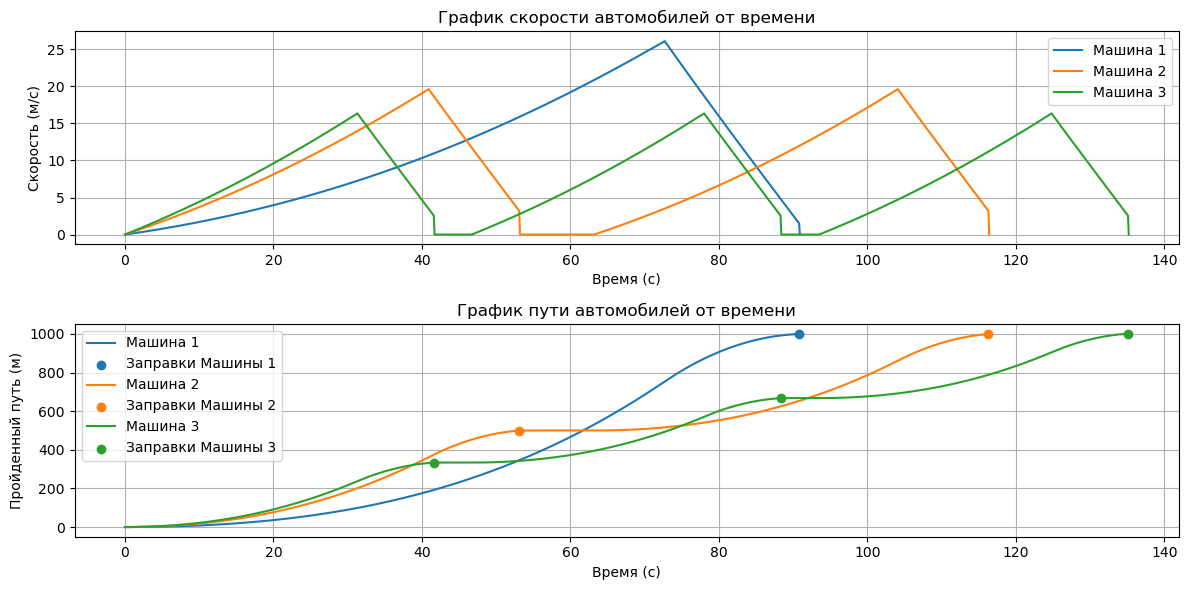

In [75]:
# Симуляция для всех машин
car_data = []
for car in cars:
    car_data.append(simulate_car(car))
    
plot_car_data(car_data)